In [1]:
import pandas as pd
import geopandas
import numpy
import json
from collections import defaultdict
import ast

/home/paulo/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
checkins = pd.read_csv("../basic_data/gowalla_checkins.csv")
places = pd.read_csv("../basic_data/places.csv")
with open("../basic_data/gowalla_category.json") as f:
    category = json.load(f)['spot_categories']


In [3]:
map_to_general_category = {}
category_names = []

In [4]:
df_names = pd.DataFrame(columns=['name', 'categoryid'])

def map_categories(data, category_map, name):
    for category in data:
        subcategory = category['name']
        category_map[subcategory] = name
        if 'spot_categories' in category:
            map_categories(category['spot_categories'], category_map, name)

def get_general_category(row):
    try:
        c_name = map_to_general_category[eval(row)[0]['name']]
        id = df_names.query(f'name == "{c_name}"')['categoryid']
        return int(id)
    except Exception as e:
        return -1
    
for i in range(len(category)):
    name = category[i]['name']
    df_names = df_names.append({'name': name, 'categoryid': i}, ignore_index=True)
    map_categories(category[i]['spot_categories'], map_to_general_category, name)


In [5]:
df_names.to_csv('../general/category_names.csv', index=False)

In [6]:
df = pd.merge(checkins, places, left_on="placeid", right_on="id")

In [7]:
df['categoryid'] = df["spot_categories"].apply(lambda x: get_general_category(x))

In [9]:
df_cpy = df.copy()

In [10]:
df[df['categoryid'] == -1].to_csv('../general/gowalla_checkins_no_category.csv', index=False)

In [12]:
df[df['categoryid'] == -1]['spot_categories'].apply(lambda x: eval(x)[0]['name']).value_counts()

Starbucks                           18431
Plaza / Square                      10548
Other - College & Education          9296
Other - Travel & Lodging             7303
Apple Store                          7208
                                    ...  
Music > Showcase > Dance                1
Interactive > Robotics > Solo           1
Film > Panel > 3D                       1
Interactive > Education > Panel         1
Music > Panel > History of Music        1
Name: spot_categories, Length: 298, dtype: int64

In [ ]:
df = df[df['categoryid'] != -1]
df.to_csv('../general/gowalla_checkins_with_category.csv', index=False)

In [13]:
df['categoryid'].value_counts()

 2    231005
 5    219269
-1    166896
 0    161154
 6     97920
 1     61486
 4     56707
 3     48383
Name: categoryid, dtype: int64

In [14]:
geo_df = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lng, df.lat), crs="EPSG:4326"
)

In [15]:
countries_gdf = geopandas.read_file("../basic_data/tl_2017_us_state/tl_2017_us_state.shp")

In [16]:
countries_gdf = countries_gdf[["NAME", "geometry"]]

<AxesSubplot:>

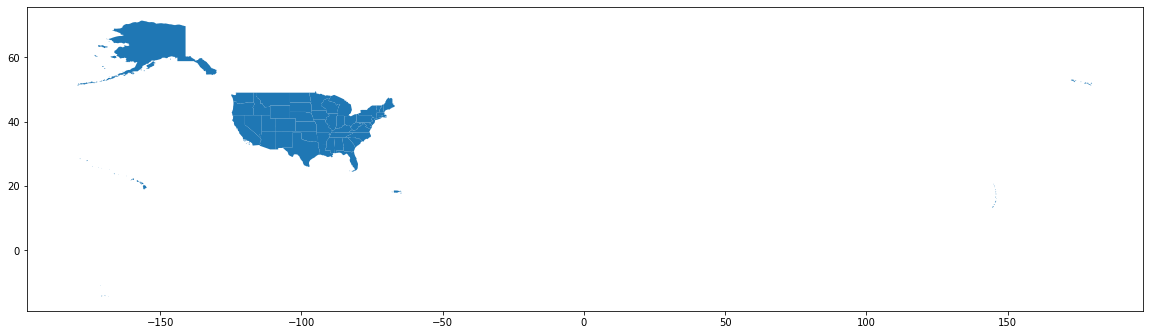

In [17]:
countries_gdf.plot(figsize=(20, 10))

In [18]:
countries_gdf = countries_gdf.to_crs("EPSG:4326")

In [19]:
geo_df = geo_df.sjoin(countries_gdf, how="left", predicate="intersects")

In [21]:
geo_df.NAME.unique()

array(['Minnesota', 'Illinois', 'Nebraska', 'Ohio', 'Wisconsin',
       'Georgia', 'Iowa', 'Indiana', 'Missouri', 'Kansas', 'Nevada',
       'Tennessee', 'Alabama', 'Mississippi', 'California', 'New York',
       'Florida', nan, 'Texas', 'Virginia', 'North Carolina', 'Louisiana',
       'Washington', 'District of Columbia', 'Maryland', 'Pennsylvania',
       'Kentucky', 'Connecticut', 'Massachusetts', 'Delaware',
       'New Jersey', 'Guam', 'Hawaii', 'Colorado', 'Rhode Island', 'Utah',
       'Oregon', 'Arizona', 'Michigan', 'Oklahoma', 'Arkansas',
       'West Virginia', 'South Carolina', 'New Mexico', 'North Dakota',
       'New Hampshire', 'Maine', 'South Dakota', 'Montana', 'Wyoming',
       'Idaho', 'Vermont', 'Puerto Rico', 'Alaska',
       'United States Virgin Islands'], dtype=object)

In [23]:
geo_df["placeid"] =  geo_df["id"]
geo_df.head()

,userid,placeid,datetime,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories,categoryid,geometry,index_right,NAME
0,1338,482954,2011-06-23T02:24:22Z,482954,2010-01-31T03:43:41Z,-93.177506,44.934198,4,50,33,50,0,5,10,"[{'url': '/categories/241', 'name': 'Bar'}]",3,POINT (-93.17751 44.93420),3.0,Minnesota
1,116691,482954,2011-06-05T17:42:29Z,482954,2010-01-31T03:43:41Z,-93.177506,44.934198,4,50,33,50,0,5,10,"[{'url': '/categories/241', 'name': 'Bar'}]",3,POINT (-93.17751 44.93420),3.0,Minnesota
2,59161,482954,2011-01-14T01:39:11Z,482954,2010-01-31T03:43:41Z,-93.177506,44.934198,4,50,33,50,0,5,10,"[{'url': '/categories/241', 'name': 'Bar'}]",3,POINT (-93.17751 44.93420),3.0,Minnesota
3,59161,482954,2010-07-23T01:32:22Z,482954,2010-01-31T03:43:41Z,-93.177506,44.934198,4,50,33,50,0,5,10,"[{'url': '/categories/241', 'name': 'Bar'}]",3,POINT (-93.17751 44.93420),3.0,Minnesota
4,149777,482954,2010-03-18T01:40:40Z,482954,2010-01-31T03:43:41Z,-93.177506,44.934198,4,50,33,50,0,5,10,"[{'url': '/categories/241', 'name': 'Bar'}]",3,POINT (-93.17751 44.93420),3.0,Minnesota


In [24]:
geo_df.to_csv("../general/gowalla_geo_checkins.csv", index=False)

In [32]:
for x in geo_df.NAME.unique():
    state =  geo_df[geo_df["NAME"]==x][["userid",  "placeid", "datetime", "categoryid", "lat", "lng"]]
    state.to_csv(f"../checkins_local/checkins_local_{x}.csv", index=False)